In [128]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import time
import os
import glob
from itertools import combinations
import copy
import backbone as backbone
import configs
from data.datamgr import SimpleDataManager, SetDataManager
from methods.baselinetrain import BaselineTrain
from methods.gnnnet import GnnNet
from methods.baselinefinetune import BaselineFinetune
from methods.protonet import ProtoNet
from methods import sbmtl_double as sbmtl
from methods import sbmtl_gnn
from methods.protonet import euclidean_dist
configs.save_dir = 'logs_final_train' ##override
from io_utils import model_dict, parse_args, get_resume_file, get_best_file, get_assigned_file 

from utils import *

from datasets import ISIC_few_shot, EuroSAT_few_shot, CropDisease_few_shot, Chest_few_shot, miniImageNet_few_shot, DTD_few_shot, CUB_few_shot, cifar_few_shot, caltech256_few_shot, cars_few_shot, plantae_few_shot, places_few_shot


class Classifier(nn.Module):
    def __init__(self, dim, n_way):
        super(Classifier, self).__init__()
        
        self.fc = nn.Linear(dim, n_way)

    def forward(self, x):
        x = self.fc(x)
        return x


def finetune_linear(liz_x,y, state_in, save_it, linear = False, flatten = True, n_query = 15, ds= False, pretrained_dataset='miniImageNet', freeze_backbone = False, n_way = 5, n_support = 5): 
    ###############################################################################################
    # load pretrained model on miniImageNet
    pretrained_model = model_dict[params.model](flatten = flatten)
    
    state_temp = copy.deepcopy(state_in)

    state_keys = list(state_temp.keys())
    for _, key in enumerate(state_keys):
        if "feature." in key:
            newkey = key.replace("feature.","")  # an architecture model has attribute 'feature', load architecture feature to backbone by casting name from 'feature.trunk.xx' to 'trunk.xx'  
            state_temp[newkey] = state_temp.pop(key)
        else:
            state_temp.pop(key)


    pretrained_model.load_state_dict(state_temp)

    
    ###############################################################################################

    classifier = Classifier(pretrained_model.final_feat_dim, n_way)

    ###############################################################################################

    x = liz_x[0] ### non-changed one
    n_query = x.size(1) - n_support
    x = x
    x_var = Variable(x)

    batch_size = 8
    support_size = n_way * n_support 
    
    y_a_i = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device) # (25,)

    x_b_i = x_var[:, n_support:,:,:,:].contiguous().view( n_way* n_query,   *x.size()[2:]) 
    x_a_i = x_var[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:]) # (25, 3, 224, 224)
    x_inn = x_var.view(n_way* (n_support + n_query), *x.size()[2:])
    
    ### to load all the changed examples
    x_a_i = torch.cat((x_a_i, x_a_i), dim = 0) ##oversample the first one
    y_a_i = torch.cat((y_a_i, y_a_i), dim = 0)
    for x_aug in liz_x[1:]:
      x_aug = Variable(x_aug)
      x_a_aug = x_aug[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:])
      y_a_aug = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) ))
      x_a_i = torch.cat((x_a_i, x_a_aug), dim = 0)
      y_a_i = torch.cat((y_a_i, y_a_aug.to(device)), dim = 0)
    
    ###############################################################################################
    loss_fn = nn.CrossEntropyLoss().to(device)
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr = 0.01, weight_decay = 0.001)
    
    names = []
    for name, param in pretrained_model.named_parameters():
      if param.requires_grad:
        #print(name)
        names.append(name)
    
    names_sub = names[:-9] ### last Resnet block can adapt

    for name, param in pretrained_model.named_parameters():
      if name in names_sub:
        param.requires_grad = False

    if freeze_backbone is False:
        delta_opt = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr = 0.01)


    pretrained_model.to(device)
    classifier.to(device)
    ###############################################################################################
    

    
    pretrained_model.train()
    classifier.train()
    total_epoch = params.fine_tune_epoch
    lengt = len(liz_x) +1
    for epoch in range(total_epoch):
        rand_id = np.random.permutation(support_size * lengt)

        for j in range(0, support_size * lengt, batch_size):
            classifier_opt.zero_grad()
            delta_opt.zero_grad()

            #####################################
            selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
            
            z_batch = x_a_i[selected_id].to(device)
            y_batch = y_a_i[selected_id] 
            #####################################

            output = pretrained_model(z_batch)
            output = classifier(output)
            loss = loss_fn(output, y_batch)

            #####################################
            loss.backward()

            classifier_opt.step()
            
            
            delta_opt.step()

    #pretrained_model.eval() ## for transduction 
    #classifier.eval()

    output = pretrained_model(x_b_i.to(device))
    score = classifier(output).detach()
    score = torch.nn.functional.softmax(score, dim = 1).detach()
    return score


def finetune_classify(liz_x,y, model, state_in, save_it, linear = False, flatten = True, n_query = 15, ds= False, pretrained_dataset='miniImageNet', freeze_backbone = False, n_way = 5, n_support = 5): 
    ###############################################################################################
    # load pretrained model on miniImageNet
    pretrained_model = copy.deepcopy(model.feature_baseline2)
    
    
    model = model.to(device)
    model.train()
    
    ###############################################################################################

    classifier = Classifier(model.feature_baseline.final_feat_dim, model.n_way)

    ###############################################################################################
    
    x = liz_x[0] ### non-changed one
    #print(x.shape)
    #print(n_query)
    model.n_query = n_query
    #x = x
    x_var = Variable(x)
    
    support_size = n_way * n_support 
    batch_size = 8

    y_a_i = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device) # (25,)

    x_b_i = x_var[:, n_support:,:,:,:].contiguous().view( n_way* n_query,   *x.size()[2:]).to(device)
    x_a_i = x_var[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:]) # (25, 3, 224, 224)
    x_a_i_original = x_a_i.to(device)
    x_inn = x_var.view(n_way* (n_support + n_query), *x.size()[2:]).to(device)
    
    ### to load all the changed examples

    x_a_i = torch.cat((x_a_i, x_a_i), dim = 0) ##oversample the first one
    y_a_i = torch.cat((y_a_i, y_a_i), dim = 0)
    for x_aug in liz_x[1:]:
      #x_aug = x_aug
      x_aug = Variable(x_aug)
      x_a_aug = x_aug[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:])
      y_a_aug = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device)
      x_a_i = torch.cat((x_a_i, x_a_aug), dim = 0)
      y_a_i = torch.cat((y_a_i, y_a_aug.to(device)), dim = 0)
    
    ###############################################################################################
    
    #optimizer = torch.optim.Adam(model.parameters())
    names = []
    for name, param in pretrained_model.named_parameters():
      if param.requires_grad:
        #print(name)
        names.append(name)
    
    names_sub = names[:-9] ### last Resnet block can adapt

    for name, param in pretrained_model.named_parameters():
      if name in names_sub:
        param.requires_grad = False

    if freeze_backbone is False:
        delta_opt = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr = 0.01)

    loss_fn = nn.CrossEntropyLoss().to(device) ##change this code up ## dorop n way
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr = 0.01) ##try it with weight_decay
    pretrained_model.to(device)
    classifier.to(device)
    ###############################################################################################
    total_epoch = params.fine_tune_epoch

    if freeze_backbone is False:
        pretrained_model.train()
    
    #pretrained_model_fixed = copy.deepcopy(pretrained_model)
    #pretrained_model_fixed.eval()
    classifier.train()
    lengt = len(liz_x) +1
    for epoch in range(total_epoch):
        rand_id = np.random.permutation(support_size * lengt)

        for j in range(0, support_size * lengt, batch_size):
            classifier_opt.zero_grad()
            if freeze_backbone is False:
                delta_opt.zero_grad()

            #####################################
            selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
            
            z_batch = x_a_i[selected_id].to(device)
            y_batch = y_a_i[selected_id] 
            #####################################

            output = pretrained_model(z_batch)
            if flatten == False:
              avgpool = nn.AvgPool2d(7)
              flat = backbone.Flatten()
              output = flat(avgpool(output))
            scores  = classifier(output)
            loss = loss_fn(scores, y_batch)

            #####################################
            loss.backward()

            classifier_opt.step()
            
            if freeze_backbone is False:
                delta_opt.step()

    
    #output_support = pretrained_model(x_a_i_original.to(device)).view(n_way, n_support, -1)
    #output_query = pretrained_model(x_b_i.to(device)).view(n_way,n_support+n_query,-1)

  

    output_all = pretrained_model(x_inn.to(device)).view(n_way, n_support + n_query, -1).detach()
    final = classifier(output_all)
    batchnorm = model.batchnorm
    final = torch.transpose(batchnorm(torch.transpose(final, 1,2)),1,2).contiguous()

    output_all_s = pretrained_model(x_b_i.to(device)).detach()
    final_s = classifier(output_all_s)
    final_s = torch.nn.functional.softmax(final_s, dim = 1).detach()

    output_all_s_2 = pretrained_model(x_a_i_original.to(device)).detach()
    final_s_2 = classifier(output_all_s_2)
    final_s_2 = torch.nn.functional.softmax(final_s_2, dim = 1).detach()


    #z = model.fc2(final.view(-1, *final.size()[2:]))
    #z = z.view(model.n_way, -1, z.size(1))
    

    if params.method == "sbmtl":
        #### copy baseline feature and instantiate classifer
        baseline_feat = copy.deepcopy(model.feature_baseline)
        classifier_baseline = Classifier(model.feature_baseline.final_feat_dim, model.n_way) ##instantiate classifier
        classifier_baseline.to(device)
    
        ### freeze layers of baseline feat
        names_b = []
        for name, param in baseline_feat.named_parameters():
            if param.requires_grad:
                #print(name)
                names.append(name)
        
        names_sub_b = names_b[:-9] ### last Resnet block can adapt

        for name, param in baseline_feat.named_parameters():
            if name in names_sub_b:
                param.requires_grad = False   

        delta_opt_b = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline_feat.parameters()), lr = 0.01)
        classifier_opt_b = torch.optim.Adam(classifier_baseline.parameters(), lr = 0.01)

        for epoch in range(total_epoch):
            rand_id = np.random.permutation(support_size * lengt)

            for j in range(0, support_size * lengt, batch_size):
                classifier_opt_b.zero_grad()
                
                delta_opt_b.zero_grad()

                #####################################
                selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
                z_batch = x_a_i[selected_id].to(device)
                y_batch = y_a_i[selected_id] 
                #####################################

                output = baseline_feat(z_batch)
                score  = classifier_baseline(output)
                loss_b = loss_fn(score, y_batch)
                #grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True)

                #####################################
                loss_b.backward() ### think about how to compute gradients and achieve a good initialization

                classifier_opt_b.step()
                delta_opt_b.step()
        
        #output_support_b = baseline_feat(x_a_i_original.to(device)).view(n_way, n_support, -1)
        #output_query_b = baseline_feat(x_b_i.to(device)).view(n_way,n_query,-1)


        output_all_b = baseline_feat(x_inn.to(device)).view(n_way, n_support + n_query, -1).detach()

        final_b = classifier_baseline(output_all_b).detach() ##initial baseline scores
        
        
        #final = torch.cat([final, final_b], dim = 2)          

        output_all_b_s = baseline_feat(x_b_i.to(device)).detach()
        final_b_s = classifier_baseline(output_all_b_s).detach() ##initial baseline scores
        final_b_s = torch.nn.functional.softmax(final_b_s, dim = 1).detach()


        output_all_b_s_2 = baseline_feat(x_a_i_original.to(device)).detach()
        final_b_s_2 = classifier_baseline(output_all_b_s_2).detach() ##initial baseline scores
        final_b_s_2 = torch.nn.functional.softmax(final_b_s_2, dim = 1).detach()


          
        final_b = torch.transpose(model.batchnorm2(torch.transpose(final_b, 1,2)),1,2).contiguous()
        z = model.fc2(final.view(-1, *final.size()[2:]))
        z = z.view(model.n_way, -1, z.size(1))

        z_b = model.fc2(final_b.view(-1, *final_b.size()[2:]))
        z_b = z_b.view(model.n_way, -1, z_b.size(1))

        z = torch.cat([z, z_b], dim = 2)

        #
        #z = model.fc_new(final.view(-1, *final.size()[2:]))
        #z = z.view(model.n_way, -1, z.size(1))
    else:
        z = model.fc2(final.view(-1, *final.size()[2:]))
        z = z.view(model.n_way, -1, z.size(1))
        #z = torch.cat([z, z_b], dim = 2) ##concatenate

    z_stack = [torch.cat([z[:, :model.n_support], z[:, model.n_support + i:model.n_support + i + 1]], dim=1).view(1, -1, z.size(2)) for i in range(n_query)]

    score = model.forward_gnn(z_stack)
    score = torch.nn.functional.softmax(score, dim = 1).detach()

    z_stack_2 = [torch.cat([z[:, :model.n_support], z[:, i:i+1]], dim=1).view(1, -1, z.size(2)) for i in range(n_query)]

    score_2 = model.forward_gnn(z_stack_2)
    score_2 = torch.nn.functional.softmax(score_2, dim = 1).detach()

    indices = [np.asarray([0,1,2,3,4]) + i*n_query for i in range(n_way)]
    print(indices)
    indices = torch.from_numpy(np.asarray(indices))
    print(indices)
    score_2 = torch.index_select(score_2, 1, )

    return score, final_s + final_b_s, score_2, final_s_2 + final_b_s_2




def finetune(liz_x,y, model, state_in, save_it, linear = False, flatten = True, n_query = 15, ds= False, pretrained_dataset='miniImageNet', freeze_backbone = False, n_way = 5, n_support = 5): 
    ###############################################################################################
    # load pretrained model on miniImageNet
    pretrained_model = model_dict[params.model](flatten = flatten)
    
    state_temp = copy.deepcopy(state_in)

    state_keys = list(state_temp.keys())
    for _, key in enumerate(state_keys):
        if "feature." in key:
            newkey = key.replace("feature.","")  # an architecture model has attribute 'feature', load architecture feature to backbone by casting name from 'feature.trunk.xx' to 'trunk.xx'  
            state_temp[newkey] = state_temp.pop(key)
        else:
            state_temp.pop(key)


    pretrained_model.load_state_dict(state_temp)

    model = model.to(device)
    
    ###############################################################################################

    ###############################################################################################
    
    x = liz_x[0] ### non-changed one
    n_query = x.size(1) - n_support
    x = x
    x_var = Variable(x)


    batch_size = 5
    support_size = n_way * n_support 
    
    y_a_i = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) )).to(device) # (25,)

    x_b_i = x_var[:, n_support:,:,:,:].contiguous().view( n_way* n_query,   *x.size()[2:]) 
    x_a_i = x_var[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:]) # (25, 3, 224, 224)
    x_inn = x_var.view(n_way* (n_support + n_query), *x.size()[2:])

    x_a_i_original = x_var[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:]) # (25, 3, 224, 224)
    
    ### to load all the changed examples

    x_a_i = torch.cat((x_a_i, x_a_i), dim = 0) ##oversample the first one
    y_a_i = torch.cat((y_a_i, y_a_i), dim = 0)
    for x_aug in liz_x[1:]:
      x_aug = x_aug
      x_aug = Variable(x_aug)
      x_a_aug = x_aug[:,:n_support,:,:,:].contiguous().view( n_way* n_support, *x.size()[2:])
      y_a_aug = Variable( torch.from_numpy( np.repeat(range( n_way ), n_support ) ))
      x_a_i = torch.cat((x_a_i, x_a_aug), dim = 0)
      y_a_i = torch.cat((y_a_i, y_a_aug.to(device)), dim = 0)
    
    #print(y_a_i)
    
    
    ###############################################################################################
    loss_fn = nn.CrossEntropyLoss().to(device) ##change this code up ## dorop n way
    #optimizer = torch.optim.Adam(model.parameters())
    names = []
    for name, param in pretrained_model.named_parameters():
      if param.requires_grad:
        #print(name)
        names.append(name)

    
    #if params.model == "ResNet10_New":
        #names_change = names[-27:-18]
        #names_change = [n for n in names_change if "shortcut" not in n]
        #names_change += names[-18:]
    #elif params.model == "ResNet10_Newv2":
        #names_change = names[-18:]
    #print(names_change)
    #print(hello)
    names_change = names[-9:]

    for name, param in pretrained_model.named_parameters():
      if name not in names_change:
        param.requires_grad = False

    if freeze_backbone is False:
        delta_opt = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr = 0.01) ## do not add weiht decay


    pretrained_model.to(device)
    ###############################################################################################
    total_epoch = params.fine_tune_epoch

    if freeze_backbone is False:
        pretrained_model.train()
    else:
        pretrained_model.eval()
    #pretrained_model_fixed = copy.deepcopy(pretrained_model)
    #pretrained_model_fixed.eval()
    lengt = len(liz_x) +1
    for epoch in range(total_epoch):
        rand_id = np.random.permutation(support_size * lengt)

        for j in range(0, support_size * lengt, batch_size):
            if freeze_backbone is False:
                delta_opt.zero_grad()

            #####################################
            selected_id = torch.from_numpy( rand_id[j: min(j+batch_size, support_size * lengt)]).to(device)
            
            z_batch = x_a_i[selected_id].to(device)
            y_batch = y_a_i[selected_id] 
            #####################################

            output = pretrained_model(z_batch)
            if flatten == False:
              avgpool = nn.AvgPool2d(7)
              flat = backbone.Flatten()
              output = flat(avgpool(output))
            #scores  = classifier(output)
            loss = loss_fn(output, y_batch)

            #####################################
            loss.backward()

            #classifier_opt.step()
            
            if freeze_backbone is False:
                delta_opt.step()

    #pretrained_model.eval() ## for transduction
    
    if not linear:
      #model.eval() ## evaluation mode ## comment for transduction learning
      if flatten == True:
        output_all = pretrained_model(x_inn.to(device)).view(n_way, n_support + n_query, -1).detach()
        output_query = pretrained_model(x_b_i.to(device)).view(n_way,n_query,-1)
      else:
        output_all = pretrained_model(x_inn).view(n_way, n_support + n_query, pretrained_model.final_feat_dim[0], pretrained_model.final_feat_dim[1], pretrained_model.final_feat_dim[2]).detach()
        output_query_original = pretrained_model(x_b_i.to(device))
        output_query = output_query_original.view(n_way, n_query, pretrained_model.final_feat_dim[0], pretrained_model.final_feat_dim[1], pretrained_model.final_feat_dim[2])
      model.n_query = n_query
      if ds == True:
        score = model.set_forward(output_all, is_feature = True, domain_shift = True)
      else:
        score = model.set_forward(output_all, is_feature = True)
      score = torch.nn.functional.softmax(score, dim = 1).detach()
    elif linear:
      output_query_original = pretrained_model(x_b_i.to(device))    
      if flatten == False:
        output_query_original = flat(avgpool(output_query_original))
      score = classifier(output_query_original).detach()
      
    #score = torch.nn.functional.softmax(score, dim = 1)

    #print(score.shape)

    #score2 = output_query.view(n_way * n_query,-1)[:,:n_way]
    #score2 = torch.nn.functional.softmax(score2, dim = 1)

    #score += score2


    return score 

In [109]:
np.random.seed(10)

##################################################################
image_size = 224
iter_num = 3
n_way  = 5
pretrained_dataset = "miniImageNet"
ds = False

n_way = 5
n_query = 15

few_shot_params = dict(n_way = 5 , n_support = 5) 

datamgr             =  EuroSAT_few_shot.SetDataManager2(image_size, n_eposide = iter_num, n_query = 15, **few_shot_params)
novel_loader        = datamgr.get_data_loader(num_aug = 17)

In [110]:
for idx, (elem) in enumerate(novel_loader):
      leng = len(elem)
      
      assert(torch.all(torch.eq(elem[0][0] , elem[1][0])) )
      _, y = elem[0]
      
      liz_x = [x for (x,y) in elem]

      x = liz_x[0]

      print(x.shape)
      break
      

/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:752: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.Rando

torch.Size([3, 224, 224])
tensor([[[-1.4500, -1.4672, -1.4672,  ..., -1.3987, -1.3987, -1.3987],
         [-1.4672, -1.4843, -1.4843,  ..., -1.3987, -1.3987, -1.3987],
         [-1.4672, -1.4843, -1.4843,  ..., -1.3987, -1.3987, -1.3987],
         ...,
         [-1.3644, -1.3644, -1.3644,  ..., -1.3987, -1.3987, -1.3987],
         [-1.3644, -1.3644, -1.3644,  ..., -1.4158, -1.4158, -1.4158],
         [-1.3644, -1.3644, -1.3644,  ..., -1.3987, -1.3987, -1.3987]],

        [[-0.9153, -0.9153, -0.9153,  ..., -0.8803, -0.8803, -0.8803],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8978, -0.8978, -0.8978],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8978, -0.8978, -0.8978],
         ...,
         [-0.9153, -0.9153, -0.9153,  ..., -0.9328, -0.9328, -0.9503],
         [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9503, -0.9503],
         [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328]],

        [[-0.3753, -0.3927, -0.3927,  ..., -0.3753, -0.3753, -0.3753],
         [-0.3927, 

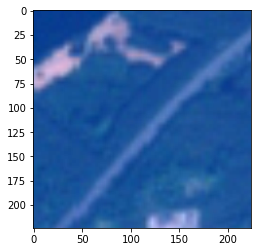

In [111]:
print(x[0][0].shape)

print(x[0][0])

import matplotlib.pyplot as plt
def renormal(a):   
    x_new = (a - a.min())
    x_new = x_new / x_new.max() 
    return x_new

plt.imshow(  renormal(x[1][0]).permute(1, 2, 0)  )

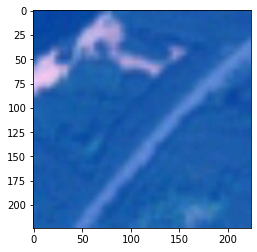

In [112]:
x2 = liz_x[7]

plt.imshow(  renormal(x2[1][0]).permute(1, 2, 0)  )

In [113]:
model           = sbmtl.GnnNet( model_dict["ResNet10"], **few_shot_params )
checkpoint_dir = "logs_final_train/checkpoints/miniImageNet/ResNet10_sbmtl_aug_5way_5shot"
modelfile   = get_assigned_file(checkpoint_dir,600)
import json
class Bunch(object):
  def __init__(self, adict):
    self.__dict__.update(adict)

with open('commandline_args.txt', 'r') as f:
   params = Bunch(json.load(f))


params.checkpoint_dir = checkpoint_dir


if modelfile is not None:
    tmp = torch.load(modelfile)
    state = tmp['state']
    state_keys = list(state.keys())
    for _, key in enumerate(state_keys):
        if "feature2." in key:
            state.pop(key)
        if "feature3." in key:
            state.pop(key)
        if "classifier2." in key:
            classifier_found = True
            state.pop(key)
        if "classifier3." in key:
            classifier_found = True
            state.pop(key)
    model.classifier = Classifier(model.feat_dim, n_way)
    model.batchnorm = nn.BatchNorm1d(5, track_running_stats=False)
    
    model.instantiate_baseline(params)
    model.load_state_dict(state)
    model.to(device)


In [129]:
for idx, (elem) in enumerate(novel_loader):
      leng = len(elem)
      
      assert(torch.all(torch.eq(elem[0][0] , elem[1][0])) )
      _, y = elem[0]
      
      liz_x = [x for (x,y) in elem]

      scores, linear_scores, scores2, linear_scores_2 = finetune_classify(liz_x,y, model, state, ds = ds, save_it = 600, n_query = 15, pretrained_dataset=pretrained_dataset, freeze_backbone=False, **few_shot_params)

      x = liz_x[0]

      break

/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/billcai/metalearning/CVPR2021/env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:752: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.Rando

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [117]:
### print out some stuff
print(scores.shape)
print(linear_scores.shape)

print(scores2.shape)
print(linear_scores_2.shape)

print(torch.argmax(scores2, dim = 1))
print(torch.argmax(linear_scores_2, dim = 1))

torch.Size([75, 5])
torch.Size([75, 5])
torch.Size([25, 5])
torch.Size([25, 5])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:1')
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4], device='cuda:1')


In [116]:
print(torch.argmax(scores, dim = 1))
print(torch.argmax(linear_scores, dim = 1))


def acc(sco):
    y_query = np.repeat(range(n_way ), n_query )

    topk_scores, topk_labels = sco.data.topk(1, 1, True, True)
    topk_ind = topk_labels.cpu().numpy()

    top1_correct = np.sum(topk_ind[:,0] == y_query)
    print(topk_ind[:,0] == y_query)
    
    correct_this, count_this = float(top1_correct), len(y_query)


    return correct_this/ count_this * 100

print(acc(scores))
print(acc(linear_scores))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 1, 2, 4, 4, 1,
        4, 4, 4], device='cuda:1')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 4, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 4, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 4, 3, 4, 1, 2, 4, 4, 1,
        3, 4, 4], device='cuda:1')
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True False False  True  True False
  True  True

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

scores_np = scores.cpu().numpy()

linear_scores_np = linear_scores.cpu().numpy()  

ls_embedded = TSNE(n_components=2).fit_transform(linear_scores_np)

sc_embedded = TSNE(n_components=2).fit_transform(scores_np)


In [59]:
print(ls_embedded)

[[ -3.7150254   -0.9813258 ]
 [-23.476604    48.709602  ]
 [-14.801144    35.029198  ]
 [-19.353806    17.185999  ]
 [-38.604927    32.309826  ]
 [ 29.121609    24.111013  ]
 [-24.28525     40.60419   ]
 [-23.395067    26.12418   ]
 [  2.4972541    9.947123  ]
 [-31.634777    45.491432  ]
 [-22.75955     33.583305  ]
 [-30.084991    29.294796  ]
 [-38.58181     40.660347  ]
 [-36.28839     24.151218  ]
 [-30.916676    36.73133   ]
 [ 31.71315     15.862303  ]
 [ 23.346325    17.207771  ]
 [ 20.557653    24.337807  ]
 [ 19.745731     4.3365445 ]
 [ 11.626221     7.072817  ]
 [-15.397854    26.532408  ]
 [ 23.918507    31.639029  ]
 [  8.683713    24.875385  ]
 [-52.918636    -4.3075376 ]
 [ 26.26223      9.344985  ]
 [ 14.973876    19.852705  ]
 [  8.634187    15.650927  ]
 [ 17.317186    12.622206  ]
 [ 14.701342    30.504166  ]
 [ -5.050969   -11.831675  ]
 [-16.199825    43.05875   ]
 [ -0.91572917 -19.55038   ]
 [-16.866686   -19.322504  ]
 [-28.361917    19.16453   ]
 [-21.861591  

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

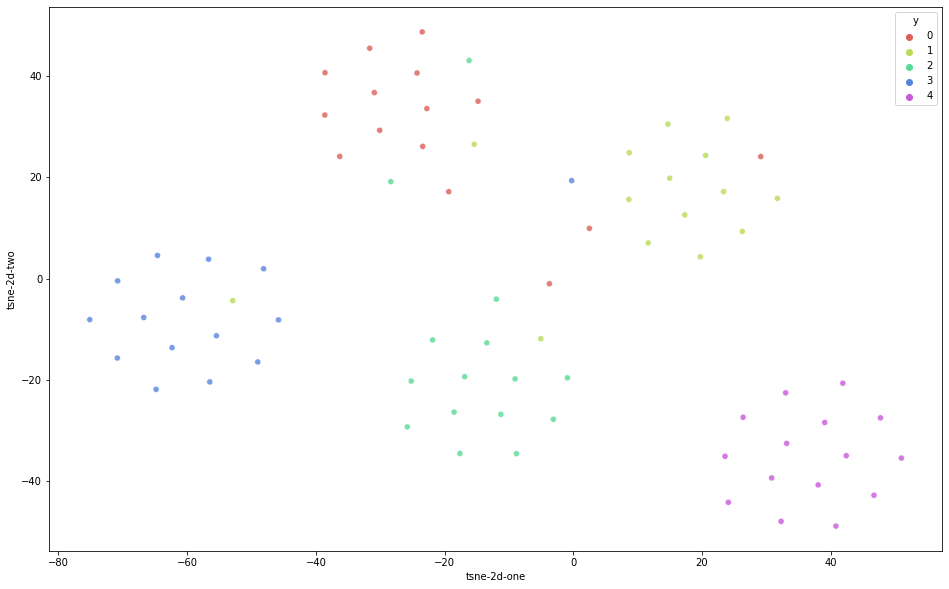

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


df_subset = pd.DataFrame({'tsne-2d-one':ls_embedded[:,0], 'tsne-2d-two': ls_embedded[:,1], "y" : list(np.repeat(range(n_way ), n_query )) })



plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df_subset,
    legend="full",
    alpha=0.8
)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]